In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
%load_ext cython
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

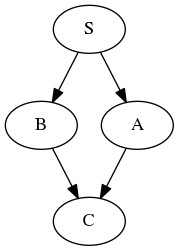

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
data = simulate(par, stim_N=1000, J_AC=2.0, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)

simulating  42447.0
stimulating  1000
connecting  J_AC 2.0


In [5]:
t_stop = data['status']['time']
spiketrains = [s['times'] for s in data['spiketrains']]
names = ['A', 'B', 'C']

In [6]:
A_spikes, B_spikes, C_spikes = spiketrains

In [7]:
stim_times = data['epoch']['times']

In [8]:
def cpdf(x, y, delta_t, sigma, f=None, **kwargs):
    '''
    Conditional probability density function (PDF) 
    for x evaluated at y + delta_t scaled by sigma that is
    p(Y=y|X=x) = sum_y(exp(-(z/sigma)^2) / (sqrt(2pi)*sigma)), 
    z = x - y - delta_t.
    '''
    f = f or st.norm.pdf
    M, N = len(x), len(y)
    pdf = np.zeros((M, N))
    for i in range(N):
        pdf[:,i] = f(x, loc=y[i] + delta_t, scale=sigma, **kwargs) / N
    return np.sum(pdf, axis=1)

In [9]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count

In [10]:
def fit_latency(pre, post, binsize=.1, limit=[-20, 0], init=[0.5, 0.5], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, p[0], p[1])
    error  = lambda p, x, y: (y - normpdf(p, x))
    (delta_t, sigma), _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf((delta_t, sigma), b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.2f} $\sigma$ {:.2f}'.format(delta_t, sigma))
        plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return delta_t, sigma

In [12]:
import numpy as np


_sqrt_2_pi = np.sqrt(2 * np.pi)


def _norm_pdf(x):
    return np.exp(- x * x / 2.0) / _sqrt_2_pi


def ref_cpdf(x, y, delta_t, sigma):
    M, N = len(x), len(y)
    pdf = np.zeros(M)
    for i in range(M):
        for j in range(N):
            z = x[i] - y[j] - delta_t
            tmp = _norm_pdf(z / sigma) / sigma
            pdf[i] = pdf[i] + tmp / N
    return pdf

In [35]:
%%cython -a
import numpy as np
from libc.math cimport exp, sqrt

cdef double _sqrt_2_pi = sqrt(2 * np.pi)


cdef double _norm_pdf(double x):
    return exp(- x * x / 2.0) / _sqrt_2_pi


def cython_cpdf(double[:] x, double[:] y, double delta_t, double sigma):
    '''
    Conditional probability density function (PDF) 
    for x evaluated at y + delta_t scaled by sigma that is
    p(Y=y|X=x) = sum_y(exp(-(z/sigma)^2) / (sqrt(2pi)*sigma)), 
    z = x - y - delta_t.
    '''
    cdef int i, j, M, N
    cdef double z, tmp
    cdef double[:] pdf
    M, N = len(x), len(y)
    pdf = np.zeros(M)
    for i in range(M):
        for j in range(N):
            z = x[i] - y[j] - delta_t
            tmp = _norm_pdf(z / sigma) / sigma
            pdf[i] = pdf[i] + tmp / N
    return np.array(pdf)

In [36]:
_pdf_A = cython_cpdf(stim_times, A_spikes, delta_t, sigma)
pdf_A = cpdf(stim_times, A_spikes, delta_t, sigma)

In [14]:
delta_t, sigma = fit_latency(A_spikes, stim_times)

In [15]:
%timeit pdf_A = cpdf(stim_times, A_spikes, delta_t, sigma) 

136 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%timeit _pdf_A = cython_cpdf(stim_times, A_spikes, delta_t, sigma)

12.7 ms ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%timeit _pdf_A = ref_cpdf(stim_times, A_spikes, delta_t, sigma)

2.59 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
np.allclose(_pdf_A, pdf_A)

True